## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['10k_PEG', '5k_PEG', '1k_PEG', '5k_PEG_NH2', 'PS_COOH', 'PS_NH2']
calcs = [2]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
        
            filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
            #print(num)
            print(filename)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)

features_10k_PEG_2mM_XY01.csv
features_10k_PEG_2mM_XY02.csv
features_10k_PEG_2mM_XY03.csv
features_10k_PEG_2mM_XY04.csv
features_10k_PEG_2mM_XY05.csv
features_10k_PEG_2mM_XY06.csv
features_10k_PEG_2mM_XY07.csv
features_10k_PEG_2mM_XY08.csv
features_10k_PEG_2mM_XY09.csv
features_10k_PEG_2mM_XY10.csv
features_5k_PEG_2mM_XY01.csv
features_5k_PEG_2mM_XY02.csv
features_5k_PEG_2mM_XY03.csv
features_5k_PEG_2mM_XY04.csv
features_5k_PEG_2mM_XY05.csv
features_5k_PEG_2mM_XY06.csv
features_5k_PEG_2mM_XY07.csv
features_5k_PEG_2mM_XY08.csv
features_5k_PEG_2mM_XY09.csv
features_5k_PEG_2mM_XY10.csv
features_1k_PEG_2mM_XY01.csv
features_1k_PEG_2mM_XY02.csv
features_1k_PEG_2mM_XY03.csv
features_1k_PEG_2mM_XY04.csv
features_1k_PEG_2mM_XY05.csv
features_1k_PEG_2mM_XY06.csv
features_1k_PEG_2mM_XY07.csv
features_1k_PEG_2mM_XY08.csv
features_1k_PEG_2mM_XY09.csv
features_1k_PEG_2mM_XY10.csv
features_5k_PEG_NH2_2mM_XY01.csv
features_5k_PEG_NH2_2mM_XY02.csv
features_5k_PEG_NH2_2mM_XY03.csv
features_5k_PEG_NH2_2

In [ ]:
fstats_tot.to_csv('features.csv')

In [3]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [4]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_totMW = fstats_sub[fstats_sub['Particle Type'].isin(['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH'])].reset_index(drop=True)
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Calcium Concentration', 'Deff2']
fstats_num = fstats_totMW.drop(nonnum, axis=1)
fstats_raw = fstats_num.values
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [5]:
pcadataset = pca.pca_analysis(fstats_totMW, dropcols=nonnum, n_components=8)

Cumulative explained variance:
0 component: 0.27482222207851964
1 component: 0.4020464886503047
2 component: 0.5052122525051459
3 component: 0.6032651904555683
4 component: 0.6820873403119736
5 component: 0.7358790312027567
6 component: 0.7878312049204752
7 component: 0.8329493706764326


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [14]:
kmostat = pca.kmo(pcadataset.scaled)

0.902559276487


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [6]:
import numpy as np
ncomp = 8
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='10k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='1k_PEG'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)

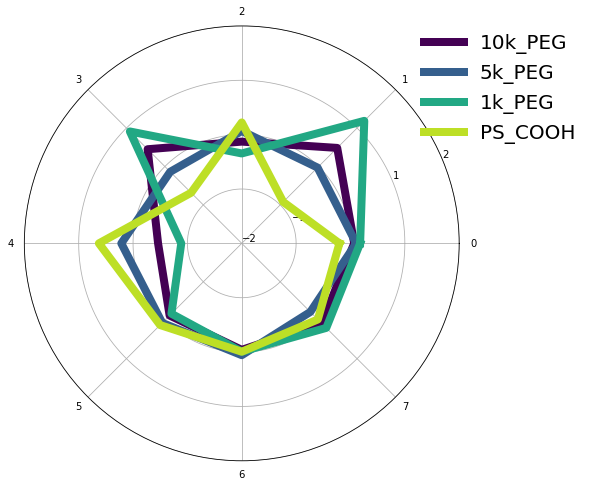

In [16]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.array([-2., -1.,  0.,  1.,  2.]))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [17]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7
0,asymmetry1,MSD_ratio,X,kurtosis,fractal_dim,Quality,SN_Ratio,fractal_dim
1,alpha,elongation,frames,asymmetry2,Deff1,SN_Ratio,Quality,AR
2,Y,kurtosis,Y,AR,D_fit,Deff1,Mean_Intensity,Mean_Intensity
3,efficiency,asymmetry2,asymmetry3,elongation,MSD_ratio,Mean_Intensity,fractal_dim,D_fit
4,boundedness,Deff1,alpha,Deff1,AR,D_fit,Deff1,efficiency


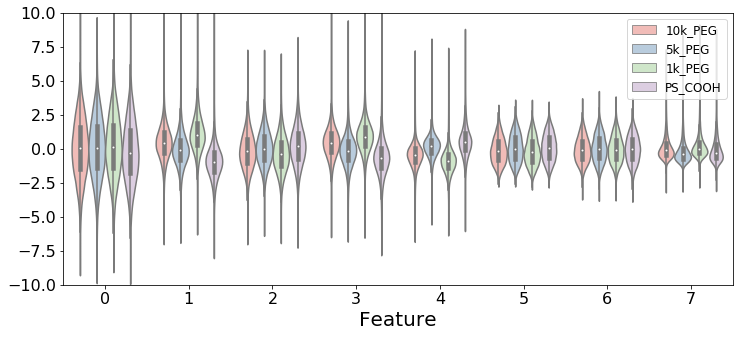

In [8]:
feats = pca.feature_violin(pcadataset.final, label='Particle Type', lvals=labels, fsubset=8, yrange=[-10, 10])

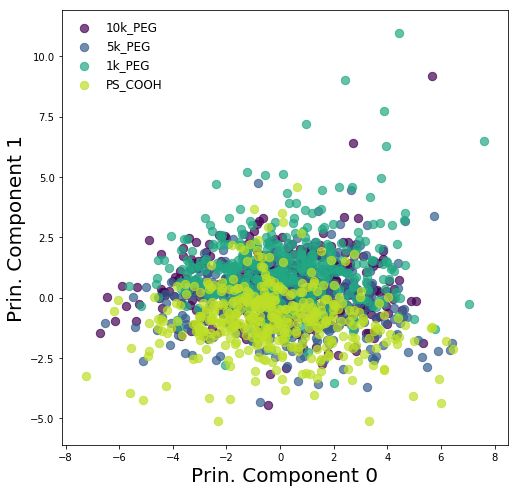

In [9]:
fstats1 = pca.feature_plot_2D(pcadataset.final, label='Particle Type', lvals=labels, randcount=400, yrange=[-6, 6],
                              xrange=[-4, 4])

In [ ]:
dataset = pcadataset.final
dataset[dataset['Particle Type'] == 'PS_COOH']

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import random

def feature_plot_3D(dataset, label, features=[0, 1, 2], lvals=['PEG', 'PS'], randsel=True,
                    randcount=200, **kwargs):

    defaults = {'figsize': (8, 8), 'dotsize': 70, 'alpha': 0.7, 'xlim': None,
                'ylim': None, 'zlim': None, 'legendfontsize': 12,
                'labelfontsize': 10, 'fname': None}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    axes = {}
    fig = plt.figure(figsize=(14, 14))
    axes[1] = fig.add_subplot(221, projection='3d')
    axes[2] = fig.add_subplot(222, projection='3d')
    axes[3] = fig.add_subplot(223, projection='3d')
    axes[4] = fig.add_subplot(224, projection='3d')
    color = iter(cm.viridis(np.linspace(0, 0.9, 3)))
    angle1 = [60, 0, 0, 0]
    angle2 = [240, 240, 10, 190]

    tgroups = {}
    xy = {}
    counter = 0
    #labels = dataset[label].unique()
    for lval in lvals:
        tgroups[counter] = dataset[dataset[label] == lval]
        #print(lval)
        #print(tgroups[counter].shape)
        counter = counter + 1

    N = len(tgroups)
    color = iter(cm.viridis(np.linspace(0, 0.9, N)))

    counter = 0
    for key in tgroups:
        c = next(color)
        xy = []
        if randsel:
            #print(range(0, len(tgroups[key][0].tolist())))
            to_plot = random.sample(range(0, len(tgroups[key][0].tolist())),
                                    randcount)
            for key2 in features:
                xy.append(list(tgroups[key][key2].tolist()[i] for i in to_plot))
        else:
            for key2 in features:
                xy.append(tgroups[key][key2])

        acount = 0
        for ax in axes:
            axes[ax].scatter(xy[0], xy[1], xy[2], c=c, s=kwargs['dotsize'], alpha=kwargs['alpha'], label=labels[counter])
            if kwargs['xlim'] is not None:
                axes[ax].set_xlim3d(kwargs['xlim'][0], kwargs['xlim'][1])
            if kwargs['ylim'] is not None:
                axes[ax].set_ylim3d(kwargs['ylim'][0], kwargs['ylim'][1])
            if kwargs['zlim'] is not None:
                axes[ax].set_zlim3d(kwargs['zlim'][0], kwargs['zlim'][1])
            axes[ax].view_init(angle1[acount], angle2[acount])
            axes[ax].set_xlabel('Prin. Component {}'.format(features[0]),
                                fontsize=kwargs['labelfontsize'])
            axes[ax].set_ylabel('Prin. Component {}'.format(features[1]),
                                fontsize=kwargs['labelfontsize'])
            axes[ax].set_zlabel('Prin. Component {}'.format(features[2]),
                                fontsize=kwargs['labelfontsize'])
            acount = acount + 1
        counter = counter + 1

    # plt.legend(fontsize=kwargs['legendfontsize'], frameon=False)
    axes[3].set_xticks([])
    axes[4].set_xticks([])

    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'])

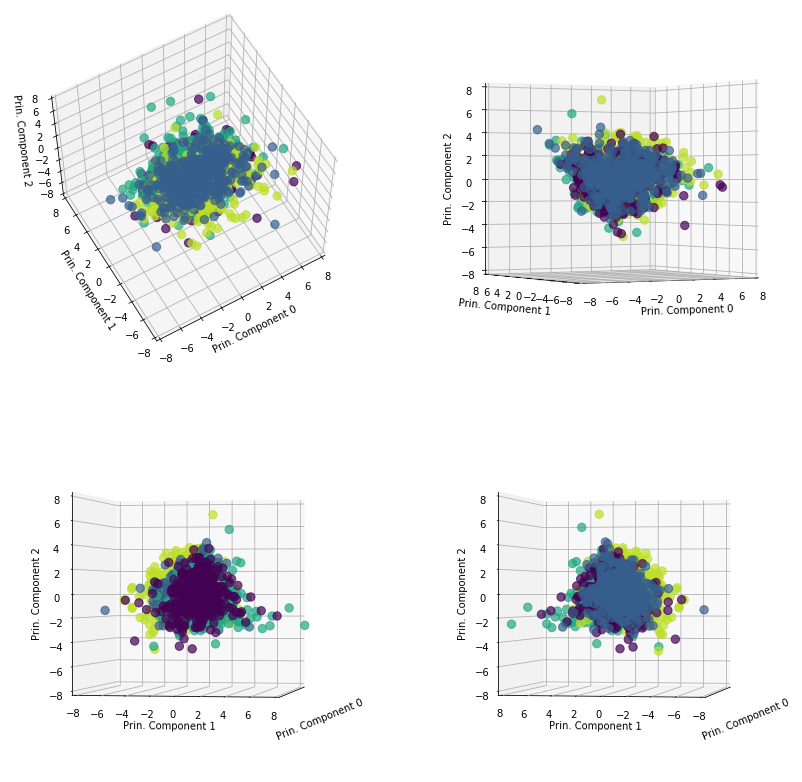

In [11]:
fstats1 = feature_plot_3D(pcadataset.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-8, 8],
                              xlim=[-8, 8], zlim=[-8, 8])

In [ ]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Particle Type', lvals=labels, randcount=200, yrange=[-6, 6],
                              xrange=[-6, 6], zrange=[-6, 6])

In [12]:
ncomp = 8
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_KNN_model(pcadataset.final, 'Particle Type', labels, equal_sampling=True,
                                       tsize=500, n_neighbors=6, input_cols=ncomp)
    trainp = np.append(trainp, pca.predict_KNN(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Type'].values
    testp = np.append(testp, pca.predict_KNN(KNNmod, X2, y2))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.735175 +/ 0.011218595054640306
0.611947958630763 +/ 0.0038995346334909386
